## mpstat jupyter notebook 
To run open in VSCode with a sourced virtual enviornment via python3 -m venv venv
or directly from the command line with jupyter notebook and navigate to browser and execute all cells. 
Install packages with 
`pip install -r requirements.txt`

I have also tested with a file called short.txt which is a smaller dataset to work with. 
Or you can also see graphs for a particular subset of cpus for example just the all categories for all cpus. 



# Table of Contents
* [Introduction](#introduction)
    * [What is mpstat](#what-is-mpstat)
    * [Data Description](#data-description)
* [Data Ingest](#data-ingest)
* [Data Cleaning](#data-cleaning)
* [Data Visualization](#data-visualization)

## Introduction 

What is mpstat? Reports cpu processors related statstics. 

It captures a snapshot of what the cpu processors are doing over a period of time that 
is specified at a set interval.

#### What is mpstat? 

You can type in a terminal right now `mpstat` and you're going to get some statstics back about your computer.

The number one represents - interval parameter specifies the amount of time in seconds between each report.
The keyword ALL indicates that statistics are calculated as averages among all processors. The keyword -P Indicate the processors for which statistics are to be reported. In english - give me all processor averages at one second intervals.

`sudo mpstat -P ALL 1` 

[0] https://linux.die.net/man/1/mpstat 

#### Why choose mpstat? 

For this case 00384384, running a sosreport was failing and falling over on the PS6 instance. 
We wanted to know if one of the cpus were stuck or a process was using all of the cpu. 
We are searching for patterns in the data that would give us any indication of the the problem was.

We had a lack of prometheus access during this time.

Hypothesis is that we can detect abnormal sustained cpu frequency fluctuations over time.  <TODO Fix me within a particaular index.>

#### Data Description
Sample output mpstat.txt file 

|11:21:37  |   CPU  |  %usr |  %nice  |  %sys | %iowait |  %irq  |  %soft |  %steal |  %guest  | %gnice |  %idle
|--------  | -------| ----  | ------- | ----- | ------- | ------ | ------ | ------ | -------| ------| ------|
|11:21:38  |   all  |  0.34 |   0.00  |  8.47 |   0.04  |  0.00  |  0.17  |  0.00  | 18.28  |  0.00 |  72.64 |
|11:21:38  |     0  |  0.00 |   0.00  | 31.96 |   0.00  |  0.00  |  0.00  |  0.00  |  0.00  |  0.00 |  68.04 |
|11:21:38  |     1  |  1.23 |   0.00  |  9.88 |   0.00  |  0.00  |  0.00  |  0.00  |  0.00  |  0.00 |  88.89 |
|11:21:38  |     2  |  1.06 |   0.00  |  1.06 |   0.00  |  0.00  |  0.00  |  0.00  |  1.06  |  0.00 |  96.81 |

The data is tabular with a datetime stamp and a CPU index with each of the categorical indexes.

FYI the large dataset `mpstat.ab8713f3-6c19-479c-b662-bad058d8902c.out` is 441M and has 2.1 million rows is slow to run.

In [8]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

### Data Ingest

This code is only used for ETL pipeline of transforming the text output into JSON.

In [9]:
# Create a list to hold the JSON data
# The following code only needs to run once
# json_data = []

# # with open('output.json', 'w') as outfile,open("../short.txt","r") as f:
# with open('output-large.json','w') as outfile,open("../mpstat.ab8713f3-6c19-479c-b662-bad058d8902c.out") as f:
#      # Split the input data into lines
#      next(f)
#      headers = []
#      for line in f:
#          if line is None or line == '\n': 
#             continue
#          else:
#             lines = line.strip().split(' ')
#             lines = list(filter(None, lines))
#             # Extract the headers
#             if len(headers) == 0:
#                headers = lines[1:]
#                continue
            
#             datetime = lines[0]               
#             row_dict = { "timestamp": datetime}
                  
#             for i in range(len(headers)):
#                k = headers[i]
#                v = lines[i+1]
#                row_dict[k] = v
#             json_data.append(row_dict)

#      json.dump(json_data, outfile)

Load data into Pandas dataframe. 

The output-large.json file is 463MB.

In [10]:
with open('output-large.json', 'r') as infile: 
    data = json.load(infile)
    result = pd.json_normalize(data, errors='raise')
df = pd.DataFrame(result)
df.head()

,timestamp,CPU,%usr,%nice,%sys,%iowait,%irq,%soft,%steal,%guest,%gnice,%idle
0,11:21:38,all,0.34,0.00,8.47,0.04,0.00,0.17,0.00,18.28,0.00,72.64
1,11:21:38,0,0.00,0.00,31.96,0.00,0.00,0.00,0.00,0.00,0.00,68.04
2,11:21:38,1,1.23,0.00,9.88,0.00,0.00,0.00,0.00,0.00,0.00,88.89
3,11:21:38,2,1.06,0.00,1.06,0.00,0.00,0.00,0.00,1.06,0.00,96.81
4,11:21:38,3,0.00,0.00,5.10,0.00,0.00,0.00,0.00,0.00,0.00,94.90


### Data Cleaning

In [11]:
# only show two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe

<bound method NDFrame.describe of         timestamp  CPU  %usr %nice   %sys %iowait  %irq %soft %steal  %guest  \
0        11:21:38  all  0.34  0.00   8.47    0.04  0.00  0.17   0.00   18.28   
1        11:21:38    0  0.00  0.00  31.96    0.00  0.00  0.00   0.00    0.00   
2        11:21:38    1  1.23  0.00   9.88    0.00  0.00  0.00   0.00    0.00   
3        11:21:38    2  1.06  0.00   1.06    0.00  0.00  0.00   0.00    1.06   
4        11:21:38    3  0.00  0.00   5.10    0.00  0.00  0.00   0.00    0.00   
...           ...  ...   ...   ...    ...     ...   ...   ...    ...     ...   
2157906  13:41:03  251  0.00  0.00  15.00    0.00  0.00  0.00   0.00   55.00   
2157907  13:41:03  252  0.00  0.00   0.00    0.00  0.00  0.00   0.00  100.00   
2157908  13:41:03  253  0.00  0.00   0.00    0.00  0.00  0.00   0.00    0.00   
2157909  13:41:03  254  1.00  0.00   0.00    0.00  0.00  0.00   0.00   69.00   
2157910  13:41:03  255  0.00  0.00   0.00    0.00  0.00  0.00   0.00    0.00   

     

Data Types will need to be updated to be working properly in a chart. 

In [12]:
df.dtypes

timestamp    object
CPU          object
%usr         object
%nice        object
%sys         object
%iowait      object
%irq         object
%soft        object
%steal       object
%guest       object
%gnice       object
%idle        object
dtype: object

Rename column headers

In [13]:
df.rename(columns={'CPU':'cpu', '%usr':'usr','%nice':'nice','%iowait':'iowait','%irq':'irq','%soft':'soft','%steal':'steal','%guest':'guest','%sys':'sys','%gnice':'gnice','%idle':'idle'}, inplace=True)

In [14]:
df.head()

,timestamp,cpu,usr,nice,sys,iowait,irq,soft,steal,guest,gnice,idle
0,11:21:38,all,0.34,0.00,8.47,0.04,0.00,0.17,0.00,18.28,0.00,72.64
1,11:21:38,0,0.00,0.00,31.96,0.00,0.00,0.00,0.00,0.00,0.00,68.04
2,11:21:38,1,1.23,0.00,9.88,0.00,0.00,0.00,0.00,0.00,0.00,88.89
3,11:21:38,2,1.06,0.00,1.06,0.00,0.00,0.00,0.00,1.06,0.00,96.81
4,11:21:38,3,0.00,0.00,5.10,0.00,0.00,0.00,0.00,0.00,0.00,94.90


The CPU column already exists at the top, we remove those extra headers from the dataset.

We only need one header row for the dataset. 

```
11:21:38     254    0.00    0.00    0.00    0.00    0.00    0.00    0.00  100.00    0.00    0.00
11:21:38     255    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00  100.00

11:21:38     CPU    %usr   %nice    %sys %iowait    %irq   %soft  %steal  %guest  %gnice   %idle
11:21:39     all    0.38    0.00    9.73    0.78    0.00    0.25    0.00   16.74    0.00   72.04
11:21:39       0    1.20    0.00    0.00    0.00    0.00    0.00    0.00    7.23    0.00   91.57
```

In [15]:
substring = ['cpu']
df = df[df['cpu'].str.contains("CPU")==False]
df.head()

,timestamp,cpu,usr,nice,sys,iowait,irq,soft,steal,guest,gnice,idle
0,11:21:38,all,0.34,0.00,8.47,0.04,0.00,0.17,0.00,18.28,0.00,72.64
1,11:21:38,0,0.00,0.00,31.96,0.00,0.00,0.00,0.00,0.00,0.00,68.04
2,11:21:38,1,1.23,0.00,9.88,0.00,0.00,0.00,0.00,0.00,0.00,88.89
3,11:21:38,2,1.06,0.00,1.06,0.00,0.00,0.00,0.00,1.06,0.00,96.81
4,11:21:38,3,0.00,0.00,5.10,0.00,0.00,0.00,0.00,0.00,0.00,94.90


Convert timestamp from string to actual datetime

In [16]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S').dt.time

/tmp/ipykernel_47539/2610453095.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
df.iloc[:,1:]

,cpu,usr,nice,sys,iowait,irq,soft,steal,guest,gnice,idle
0,all,0.34,0.00,8.47,0.04,0.00,0.17,0.00,18.28,0.00,72.64
1,0,0.00,0.00,31.96,0.00,0.00,0.00,0.00,0.00,0.00,68.04
2,1,1.23,0.00,9.88,0.00,0.00,0.00,0.00,0.00,0.00,88.89
3,2,1.06,0.00,1.06,0.00,0.00,0.00,0.00,1.06,0.00,96.81
4,3,0.00,0.00,5.10,0.00,0.00,0.00,0.00,0.00,0.00,94.90
...,...,...,...,...,...,...,...,...,...,...,...
2157906,251,0.00,0.00,15.00,0.00,0.00,0.00,0.00,55.00,0.00,30.00
2157907,252,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00
2157908,253,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00
2157909,254,1.00,0.00,0.00,0.00,0.00,0.00,0.00,69.00,0.00,30.00


In [18]:
df.iloc[:1,1:-1]

,cpu,usr,nice,sys,iowait,irq,soft,steal,guest,gnice
0,all,0.34,0.00,8.47,0.04,0.00,0.17,0.00,18.28,0.00


Remove the "all" from CPU column as this will skew our statistics. 

Place `all` rows in new dataframe.

In [19]:
# handle all seperately 
substring = ['all']
all_df = df[df['cpu'].str.contains("all")==True]
all_df.head()

,timestamp,cpu,usr,nice,sys,iowait,irq,soft,steal,guest,gnice,idle
0,11:21:38,all,0.34,0.00,8.47,0.04,0.00,0.17,0.00,18.28,0.00,72.64
258,11:21:39,all,0.38,0.00,9.73,0.78,0.00,0.25,0.00,16.74,0.00,72.04
516,11:21:40,all,0.43,0.00,9.29,0.21,0.00,0.15,0.00,16.51,0.00,73.36
774,11:21:41,all,0.31,0.00,10.21,0.09,0.00,0.10,0.00,17.65,0.00,71.56
1032,11:21:42,all,0.38,0.00,8.93,0.17,0.00,0.18,0.00,18.39,0.00,71.85


In [20]:
df = df[df['cpu'].str.contains("all")==False]
df.head()

,timestamp,cpu,usr,nice,sys,iowait,irq,soft,steal,guest,gnice,idle
1,11:21:38,0,0.00,0.00,31.96,0.00,0.00,0.00,0.00,0.00,0.00,68.04
2,11:21:38,1,1.23,0.00,9.88,0.00,0.00,0.00,0.00,0.00,0.00,88.89
3,11:21:38,2,1.06,0.00,1.06,0.00,0.00,0.00,0.00,1.06,0.00,96.81
4,11:21:38,3,0.00,0.00,5.10,0.00,0.00,0.00,0.00,0.00,0.00,94.90
5,11:21:38,4,0.00,0.00,26.04,0.00,0.00,0.00,0.00,0.00,0.00,73.96


All data should now be float because of decimal except for timestamp.

In [21]:
df[df.columns[1:]] = df[df.columns[1:]].astype(float)
df.head()

,timestamp,cpu,usr,nice,sys,iowait,irq,soft,steal,guest,gnice,idle
1,11:21:38,0.00,0.00,0.00,31.96,0.00,0.00,0.00,0.00,0.00,0.00,68.04
2,11:21:38,1.00,1.23,0.00,9.88,0.00,0.00,0.00,0.00,0.00,0.00,88.89
3,11:21:38,2.00,1.06,0.00,1.06,0.00,0.00,0.00,0.00,1.06,0.00,96.81
4,11:21:38,3.00,0.00,0.00,5.10,0.00,0.00,0.00,0.00,0.00,0.00,94.90
5,11:21:38,4.00,0.00,0.00,26.04,0.00,0.00,0.00,0.00,0.00,0.00,73.96


In [22]:
df.dtypes

timestamp     object
cpu          float64
usr          float64
nice         float64
sys          float64
iowait       float64
irq          float64
soft         float64
steal        float64
guest        float64
gnice        float64
idle         float64
dtype: object

In [23]:
df.describe()

,cpu,usr,nice,sys,iowait,irq,soft,steal,guest,gnice,idle
count,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00
mean,127.50,0.40,0.00,8.19,0.16,0.00,0.08,0.00,15.19,0.00,75.99
std,73.90,2.47,0.00,18.01,1.37,0.00,0.78,0.00,29.37,0.00,33.64
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,63.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,63.27
50%,127.50,0.00,0.00,1.01,0.00,0.00,0.00,0.00,0.00,0.00,95.00
75%,191.25,0.00,0.00,5.10,0.00,0.00,0.00,0.00,12.24,0.00,99.00
max,255.00,100.00,0.00,100.00,100.00,0.00,87.00,0.00,100.00,0.00,100.00


In [24]:
# drop columns that have 0 average 
s = df.describe() 
count = s[:1]
print(count)
s = s.iloc[1:,1:]
s

             cpu        usr       nice        sys     iowait        irq  \
count 2141184.00 2141184.00 2141184.00 2141184.00 2141184.00 2141184.00   

            soft      steal      guest      gnice       idle  
count 2141184.00 2141184.00 2141184.00 2141184.00 2141184.00  


,usr,nice,sys,iowait,irq,soft,steal,guest,gnice,idle
mean,0.40,0.00,8.19,0.16,0.00,0.08,0.00,15.19,0.00,75.99
std,2.47,0.00,18.01,1.37,0.00,0.78,0.00,29.37,0.00,33.64
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,63.27
50%,0.00,0.00,1.01,0.00,0.00,0.00,0.00,0.00,0.00,95.00
75%,0.00,0.00,5.10,0.00,0.00,0.00,0.00,12.24,0.00,99.00
max,100.00,0.00,100.00,100.00,0.00,87.00,0.00,100.00,0.00,100.00


In [25]:
s = s.drop(labels=['nice','irq','steal','gnice'], axis=1)
s

,usr,sys,iowait,soft,guest,idle
mean,0.40,8.19,0.16,0.08,15.19,75.99
std,2.47,18.01,1.37,0.78,29.37,33.64
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,63.27
50%,0.00,1.01,0.00,0.00,0.00,95.00
75%,0.00,5.10,0.00,0.00,12.24,99.00
max,100.00,100.00,100.00,87.00,100.00,100.00


### Data Visualization

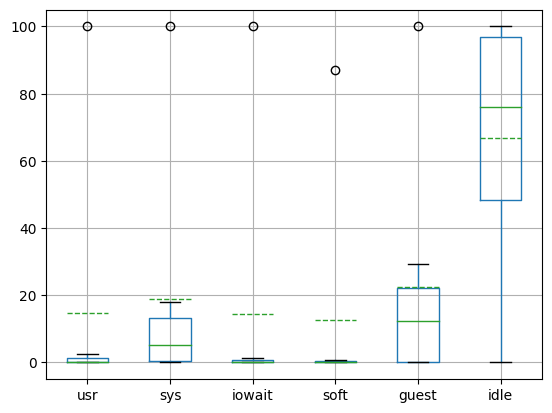

In [26]:
s.boxplot(meanline=True, showmeans=True)
plt.show()

From the boxplot we can gather that a majority of the time the CPUs sat in idle state. 

In [27]:
df = df.drop(labels=['nice','irq','steal','gnice'], axis=1)
df.head()

,timestamp,cpu,usr,sys,iowait,soft,guest,idle
1,11:21:38,0.00,0.00,31.96,0.00,0.00,0.00,68.04
2,11:21:38,1.00,1.23,9.88,0.00,0.00,0.00,88.89
3,11:21:38,2.00,1.06,1.06,0.00,0.00,1.06,96.81
4,11:21:38,3.00,0.00,5.10,0.00,0.00,0.00,94.90
5,11:21:38,4.00,0.00,26.04,0.00,0.00,0.00,73.96


In [28]:
df.describe()

,cpu,usr,sys,iowait,soft,guest,idle
count,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00,2141184.00
mean,127.50,0.40,8.19,0.16,0.08,15.19,75.99
std,73.90,2.47,18.01,1.37,0.78,29.37,33.64
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,63.75,0.00,0.00,0.00,0.00,0.00,63.27
50%,127.50,0.00,1.01,0.00,0.00,0.00,95.00
75%,191.25,0.00,5.10,0.00,0.00,12.24,99.00
max,255.00,100.00,100.00,100.00,87.00,100.00,100.00


Drop values equal to 0

In [29]:
df = df[(df != 0).all(1)]
df.head()

,timestamp,cpu,usr,sys,iowait,soft,guest,idle
522,11:21:40,5.00,1.02,6.12,3.06,2.04,64.29,23.47
4185,11:21:54,56.00,0.98,12.75,0.98,0.98,21.57,62.75
9299,11:22:14,10.00,1.00,20.00,1.00,1.00,3.00,74.00
11185,11:22:21,90.00,1.01,1.01,1.01,1.01,15.15,80.81
14475,11:22:34,26.00,1.02,40.82,1.02,3.06,2.04,52.04


In [30]:
df.shape

(321, 8)

In [31]:
df = df.sort_values(by='timestamp')

In [32]:
df.head()

,timestamp,cpu,usr,sys,iowait,soft,guest,idle
522,11:21:40,5.00,1.02,6.12,3.06,2.04,64.29,23.47
4185,11:21:54,56.00,0.98,12.75,0.98,0.98,21.57,62.75
9299,11:22:14,10.00,1.00,20.00,1.00,1.00,3.00,74.00
11185,11:22:21,90.00,1.01,1.01,1.01,1.01,15.15,80.81
14475,11:22:34,26.00,1.02,40.82,1.02,3.06,2.04,52.04


In [33]:
df = df.groupby(['cpu']).apply(lambda x: x)
df.head()

/tmp/ipykernel_47539/1906777646.py:1: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



,timestamp,cpu,usr,sys,iowait,soft,guest,idle
522,11:21:40,5.00,1.02,6.12,3.06,2.04,64.29,23.47
4185,11:21:54,56.00,0.98,12.75,0.98,0.98,21.57,62.75
9299,11:22:14,10.00,1.00,20.00,1.00,1.00,3.00,74.00
11185,11:22:21,90.00,1.01,1.01,1.01,1.01,15.15,80.81
14475,11:22:34,26.00,1.02,40.82,1.02,3.06,2.04,52.04


In [34]:
df = df.sort_values(by='timestamp')
for col in df.columns[2:]:
    fig = px.scatter(data_frame=df, x='timestamp', y=col, color='cpu', title=col +' over time')
    fig.show()

In [35]:
df = df.sort_values(by='timestamp')
for col in df.columns[2:]:
    fig = px.histogram(data_frame=df, x='timestamp', y=col,title=col +' over time')
    fig.show()

In Conclusion: 

Our results are inconclusive as this is only a two hour timeframe and we did not see any abnormalities detected with this particular dataset. There is a larger dataset avaiable and some abnormalities could have been detected.

The fix to this case was upgrading the kernel to latest 6.8 version from 6.5. Fixes to the 6.8 kernel include CPU frequency scaling and task scheduler and CPU Load Balancing.

We were able to take seemingly disparate data and transform it into something useful.
We have effectively shown what you would see in a graphing tool like grafana or prometheus when these tools are unavailable.

The biggest difference between grafana and a jupyter notebook is the level of control that you have over the charts not including the data analysis techinques that could be applied such as regression, classification, or deep learning. 

Why does this matter? 
Through data analysis and visualization we have transformed a text file into JSON to a pandas dataframe, cleaned the data and shown data visualizations via Plotly. 

Data visualization is meant to tell a story about the data. To ultimately gather important insights and make the best informed decision possible.

Future Plans:

The notebook could be expanded to handle larger datasets.

Improved data visualizations.

This could be upgraded into a new tool that could be helpful for engineers in the future if such a problem does occur again.